<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [39]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv
import catboost as cb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 

from sklearn.metrics import make_scorer, mean_squared_error 

In [40]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0]) 

In [41]:
display(data.index.is_monotonic)
display(data.head(10))
data.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


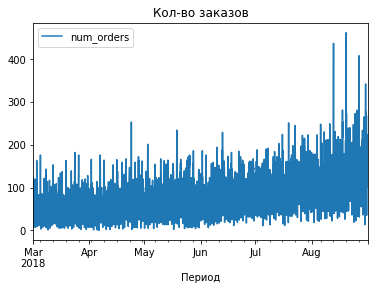

In [42]:
data = data.resample('1H').sum()
data.plot()
plt.xlabel('Период')
plt.title('Кол-во заказов')
plt.show()

Мы сделали предобработку данных и посмотрели на наши данные с количеством вызово за каждый час. Данные имеют большую частоту.

## Анализ

In [43]:
# смотрим лимиты
display('Starting date:',data.index.min())
display('Ending date:',data.index.max())
display('Total time:',data.index.max() - data.index.min())
display()
data.describe()

'Starting date:'

Timestamp('2018-03-01 00:00:00', freq='H')

'Ending date:'

Timestamp('2018-08-31 23:00:00', freq='H')

'Total time:'

Timedelta('183 days 23:00:00')

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


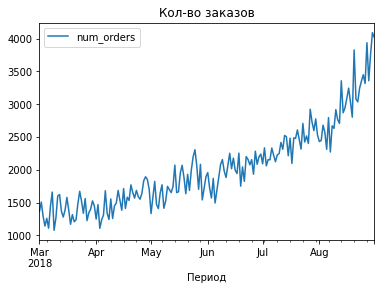

In [6]:
# посмотрим на график вызовов по дням:
data.resample('1D').sum().plot()
plt.title('Кол-во заказов')
plt.xlabel('Период');

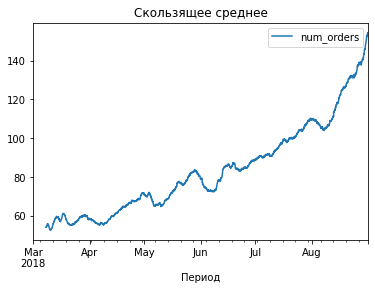

In [7]:
data.rolling(168).mean().plot()
plt.title('Скользящее среднее')
plt.xlabel('Период');

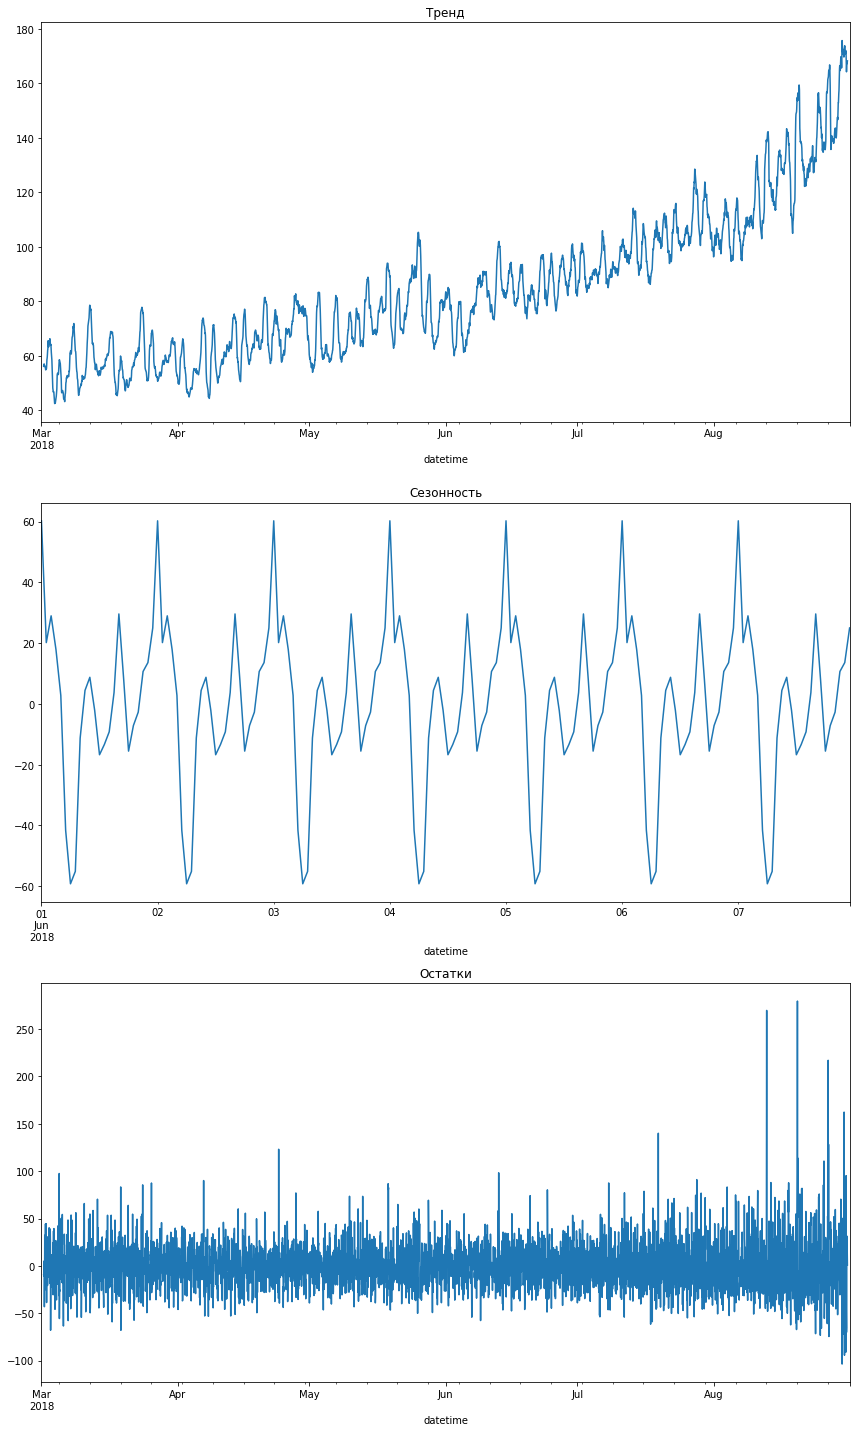

In [44]:
# проведем анализ временных рядов
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-07'].plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

In [9]:
# закрыл лишний код
#decomposed = seasonal_decompose(data['2018-06-01':'2018-06-07'])
#plt.figure(figsize=(12, 20))
#plt.subplot(311)
#decomposed.trend.plot(ax=plt.gca())
#plt.title('Тренд')
#plt.subplot(312)
#decomposed.seasonal.plot(ax=plt.gca())
#plt.title('Сезонность')
#plt.subplot(313)
#decomposed.resid.plot(ax=plt.gca())
#plt.title('Остатки')
#plt.tight_layout()

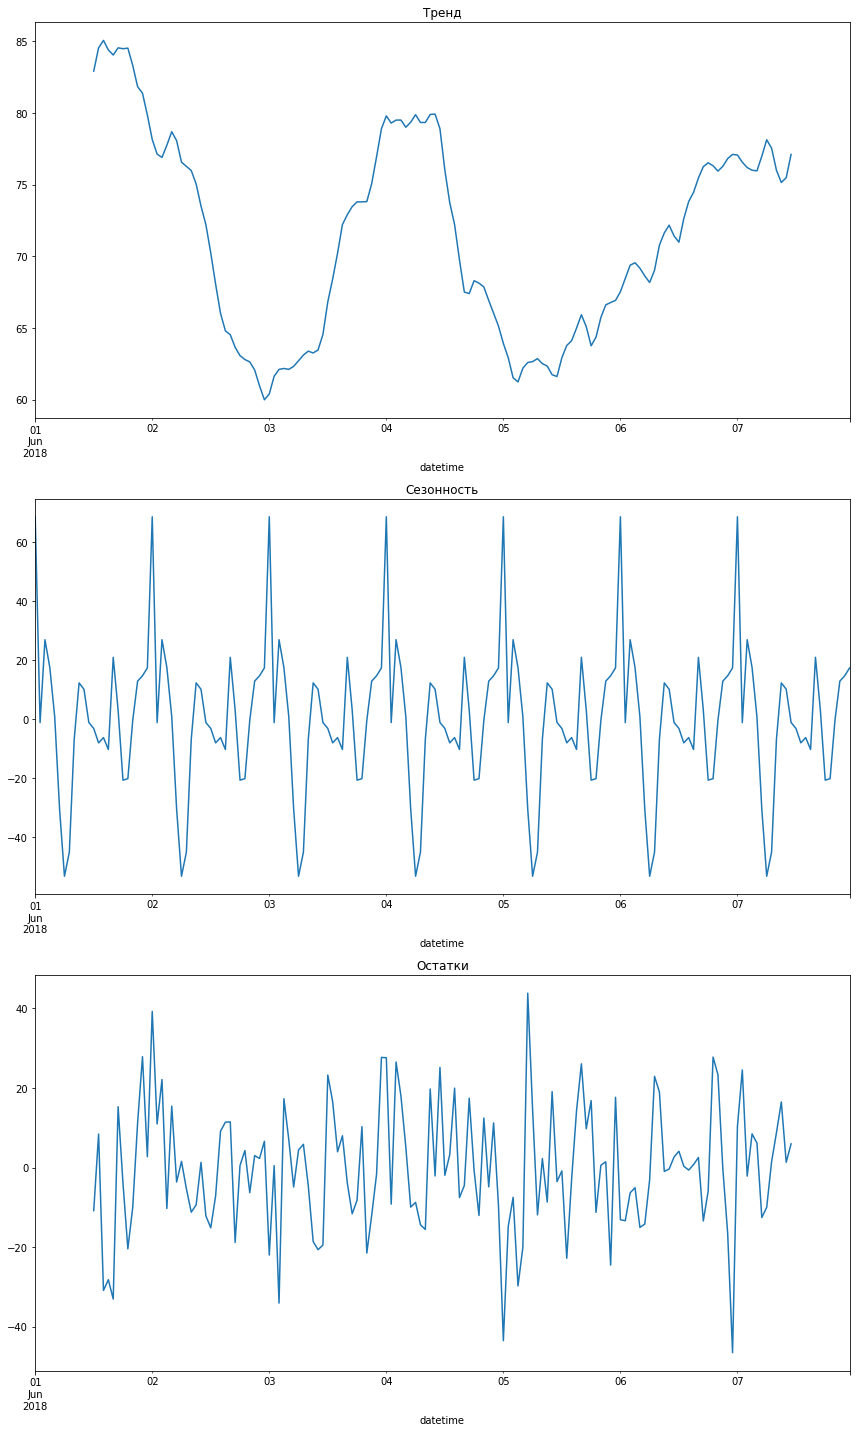

In [10]:
# уменьшим интервал посмотрим за неделю
decomposed = seasonal_decompose(data['2018-06-01':'2018-06-07'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Т.к. среднее значение меняется - наш ряд не стационарный, попробуем найти разности временного ряда.

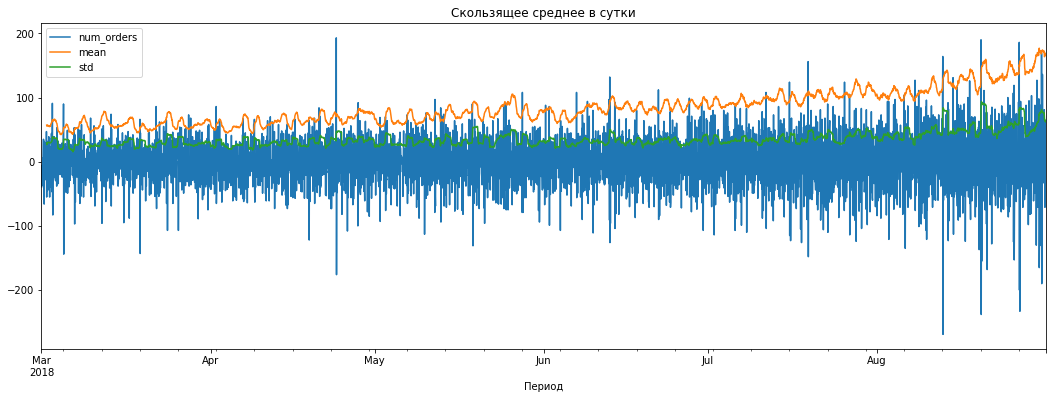

In [46]:
# создадим копию исходного датасета
shift = data - data.shift()
shift['mean'] = data['num_orders'].rolling(24).mean()
shift['std'] = data['num_orders'].rolling(24).std()
shift.plot(figsize=(18, 6))
plt.xlabel('Период')
plt.title('Скользящее среднее в сутки');

Мы проанализировали наш временной ряд, можно заметить селедующие закономерности:


* виден восходящий тренд от марта к сентябрю, сильный в августе, вероятно сезон отпусков
* видно увеличение количества заказов в понедельник с вечера и до утра, вероятно прилёты перед началом рабочей недели, а также видны внутридневные пики около 10 утра и 17 вечера

## Обучение

In [12]:
# Создадим признаки для обучения модели
max_lag = 168
rolling_mean_size = 168
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [13]:
data_copy = data.copy()

make_features(data,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=1515)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

**LinearRegression**

In [34]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
regressor = LinearRegression()
cv_RMSE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_root_mean_squared_error').mean()) * -1
display('RMSE CV of LinearRegression =', cv_RMSE_LR)

'RMSE CV of LinearRegression ='

22.540632768868388

CPU times: user 648 ms, sys: 992 ms, total: 1.64 s
Wall time: 1.6 s


In [35]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])

cv_RMSE_LR_S = (cross_val_score(pipeline, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()) * -1
display('RMSE CV of LinearRegression =', cv_RMSE_LR_S)

'RMSE CV of LinearRegression ='

22.541243075702514

CPU times: user 824 ms, sys: 914 ms, total: 1.74 s
Wall time: 1.65 s


 **DecisionTree**

In [16]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 15)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]


clf = GridSearchCV(regressor, hyperparams, scoring='neg_root_mean_squared_error', cv=tscv)
clf.fit(features_train, target_train)

display("Best parameters")
display(clf.best_params_)

display("Grid scores on development set:")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    display("%0.6f for %r"% ((mean*-1)** 0.5, params))
display()
display('cv_RMSE_DTR')
display(clf.best_score_* (-1))


'Best parameters'

{'criterion': 'mse', 'max_depth': 4, 'random_state': 1515}

'Grid scores on development set:'

"5.338848 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 1515}"

"5.170811 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 1515}"

"5.132824 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 1515}"

"5.253326 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 1515}"

"5.387388 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 1515}"

"5.467311 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 1515}"

"5.570396 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 1515}"

"5.661087 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}"

"5.740763 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 1515}"

"5.716994 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 1515}"

"5.754264 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 1515}"

"5.828342 for {'criterion': 'mse', 'max_depth': 13, 'random_state': 1515}"

"5.831626 for {'criterion': 'mse', 'max_depth': 14, 'random_state': 1515}"

'cv_RMSE_DTR'

26.34588057153627

CPU times: user 9.09 s, sys: 0 ns, total: 9.09 s
Wall time: 9.19 s


**CatBoost**

In [17]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.2, 0.3],
                'random_state':[1515],
                'verbose':[False]}]


clf = GridSearchCV(regressor, hyperparams, scoring='neg_root_mean_squared_error', cv=tscv)
clf.fit(features_train, target_train)
display("Best parameters")
display(clf.best_params_)

display("Grid scores")
display()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    display("%0.6f for %r"% ((mean*-1)** 0.5, params))
display()
display('cv_RMSE_CBR')
display(clf.best_score_* (-1))


'Best parameters'

{'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}

'Grid scores'

"4.767854 for {'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}"

"4.823860 for {'learning_rate': 0.2, 'random_state': 1515, 'verbose': False}"

"4.892779 for {'learning_rate': 0.3, 'random_state': 1515, 'verbose': False}"

'cv_RMSE_CBR'

22.73242767311854

CPU times: user 7min 44s, sys: 2.3 s, total: 7min 46s
Wall time: 8min


**LGBM**

In [19]:
%%time

tscv = TimeSeriesSplit(n_splits=5)
regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[1515]}]


clf = GridSearchCV(regressor, hyperparams, scoring='neg_root_mean_squared_error', cv=tscv)
clf.fit(features_train, target_train)
display("Best parameters")

display(clf.best_params_)

display("Grid scores")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    display("%0.6f for %r"% ((mean*-1)** 0.5, params))
display()
display('RMSE_LGBMR')
display(clf.best_score_* (-1))

'Best parameters'

{'learning_rate': 0.1, 'random_state': 1515}

'Grid scores'

"4.822708 for {'learning_rate': 0.1, 'random_state': 1515}"

"4.848694 for {'learning_rate': 0.2, 'random_state': 1515}"

"4.945280 for {'learning_rate': 0.3, 'random_state': 1515}"

"5.000445 for {'learning_rate': 0.4, 'random_state': 1515}"

"5.103193 for {'learning_rate': 0.5, 'random_state': 1515}"

'RMSE_LGBMR'

23.258512484302322

CPU times: user 4min 45s, sys: 1.57 s, total: 4min 46s
Wall time: 4min 49s


## Тестирование

**LinearRegression**

40.38263799501736

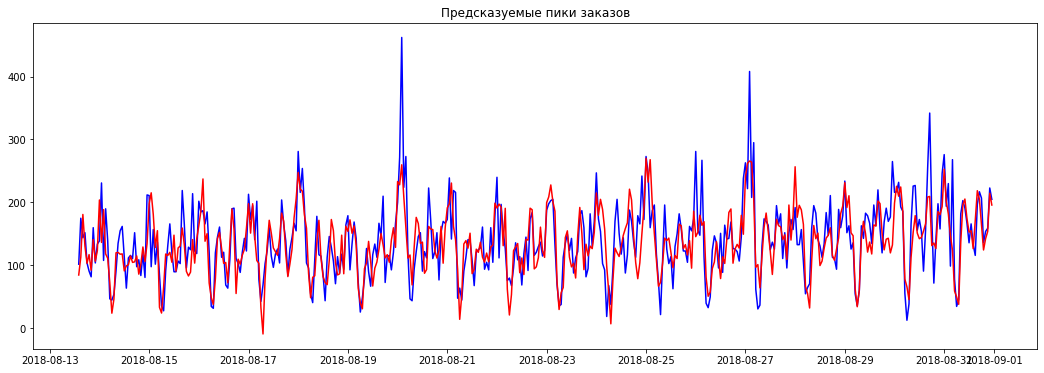

CPU times: user 441 ms, sys: 187 ms, total: 628 ms
Wall time: 561 ms


In [37]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_rmse_lr = mean_squared_error(target_test, target_predict) ** 0.5
display(test_rmse_lr)
plt.figure(figsize=(18, 6))
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')

plt.title('Предсказуемые пики заказов')
plt.show()

Мы выполнили главное условие задачи,  значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Чек-лист проверки


- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48